# Investigation of Avalanche Tendencies:
## Authors: Lucas Crichton, Omer Tahir

## Abstract:

## Introduction
Within this investigation, data from North America and Europe was explored to reveal potential trends among avalanche occurrences. The data used was provided by Avalanche Canada,the Colorado Avalanche Information Center (CAIC) and European Avalanche Warning Services (EAWS). Firstly, an exploratory analysis will be conducted to investigate the relationship between the type of activity performed at the time of the avalanches and the number of deaths caused by the avalanches. Next We will investigate whether the number of avalanche deaths are relatively even throughout the ski season or whether there is a time of the year where deadly avalanches are more common. 

## Sources:
- “Avalanche.org " Accidents.” Avalanche.org, Colorado Avalanche Information Center, 5 Feb. 2020, https://avalanche.org/avalanche-accidents/. 
- “Fatalities.” EAWS, 25 Nov. 2021, https://www.avalanches.org/fatalities/fatalities-20/. 
- “Historical Incidents.” Avalanche Canada, https://www.avalanche.ca/incidents. 


## Preparing the Data:
firstly, we must prepare the data so that our data frame for our analysis contains data from all 3 sources and all necessary variables.

## Installing Necessary Packages:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os
import urllib.request
import pandas as pd
import time
import requests
import io
import zipfile
import warnings
import re
import calendar
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from itertools import chain
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

## Scraping Data off the web

We will begin by scraping data for avalanche accidents across different regions such as Canada, the United States and Europe

### Avalanche Data (Canada):

* Scrape the Canada avalanche data from the url.
* With the help of the package `urllib`, extract the page source and decode it.
* The result is a list of dictionary objects which are combined to form a single DataFrame.
* The `id` column of the DataFrame gives access to further information for each observation. This information is extracted and added as columns to form a new DataFrame.

In [2]:
# Incidents
url = "http://incidents.avalanche.ca/public/incidents/?format=json"
req = urllib.request.Request(url)

with urllib.request.urlopen(req) as response:
    result = json.loads(response.read().decode('utf-8'))
incident_list = result["results"]

while (result["next"] != None):
    req = urllib.request.Request(result["next"])
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    incident_list = incident_list + result["results"]
incidents_brief = pd.DataFrame.from_dict(incident_list,orient="columns")

# We can get more information about these incidents e.g. "https://www.avalanche.ca/incidents/37d909e4-c6de-43f1-8416-57a34cd48255"
# this information is also available through the API
def get_incident_details(id):
    url = "http://incidents.avalanche.ca/public/incidents/{}?format=json".format(id)
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    return(result)

incidentsfile = "https://datascience.quantecon.org/assets/data/avalanche_incidents.csv"

# To avoid loading the avalanche Canada servers, we save the incident details locally.
if (not os.path.isfile(incidentsfile)):
    incident_detail_list = incidents_brief.id.apply(get_incident_details).to_list()
    incidents = pd.DataFrame.from_dict(incident_detail_list, orient="columns")
    incidents.to_csv(incidentsfile)
else:
    incidents = pd.read_csv(incidentsfile)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(incidents.head(3))

,id,ob_date,location,location_desc,location_coords,location_coords_type,location_elevation,location_province,num_involved,num_injured,num_fatal,comment,group_activity,avalanche_obs,weather_obs,weather_comment,snowpack_obs,snowpack_comment,documents
0,8bc4720d-498c-4793-81ef-c43db9f36ca4,2021-11-27,"Sunshine Bowl, Hasler Area",Approx. 17km East of Powder King ski area,"[55.366223, -122.34096]",Lat/lng,1700.0,BC,3.0,0.0,1,A party of four were snowmobiling in Sunshine ...,Snowmobiling,"[{'size': '3.0', 'type': 'S', 'trigger': 'Ma',...","{'temp_present': None, 'temp_max': None, 'temp...","Overcast, windy conditions were reported with ...","{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",A snow profile near the avalanche on the follo...,"[{'date': '2021-11-30', 'title': 'Scene photo'..."
1,6a3a4698-d047-4082-bdea-92f4db7e63bf,2021-05-30,Mount Andromeda-Skyladder,Approximately 96km SE of Jasper,"[52.17836, -117.24785]",Lat/lng,3075.0,AB,2.0,0.0,2,A party of two people were climbing the Skylad...,Mountaineering,"[{'size': '2.5', 'type': 'S', 'trigger': 'Sa',...","{'temp_present': None, 'temp_max': 8.0, 'temp_...",,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",,"[{'date': '2021-06-01', 'title': 'Mt Andromeda..."
2,ba14a125-29f7-4432-97ad-73a53207a5e7,2021-04-05,Haddo Peak,Approximately 6km SW of Lake Louise Village,"[51.38329, -116.23453]",Lat/lng,2950.0,AB,2.0,0.0,1,A party of two people were ski touring up the ...,Skiing,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...","{'temp_present': None, 'temp_max': None, 'temp...",,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",,"[{'date': '2021-04-05', 'title': 'Overview pho..."


#### Data Wrangling on Avalanche Data (Canada)

* Begin by renaming the categories in the `group_activity` column to increase interpretability. For this, we define a custom function called `clean_group_activity()` which will be used for other dataframes as well.
* Next, extract one of the dataframes nested inside a column of the `incidents` dataframe.
* Concat the `group_activity` column to the `cleaned_incidents` dataframe.
* Select only the useful columns from `incidents` dataframe and merge it with the `cleaned_incidents` dataframe to create the `ca_incidents` dataframe.


In [3]:
# clean up activity names
skiing = ['Skiing', 'Skiing/Snowboarding', 'Snowboarding',
           'Backcountry Skiing', 'Ski touring', 'Heliskiing',
           'Mechanized Skiing', 'Out-of-bounds Skiing',
           'Lift Skiing Closed', 'Lift Skiing Open', 'Out-of-Bounds Skiing', 
          'Off-piste skiing', 'Backcountry skiing', 'On skiruns', 'Ski', 'Snowboard']
climbing = ['Mountaineering','Snow Biking','Snowshoeing',
            'Foot','Ice Climbing', 'Snowshoeing & Hiking',
            'Mountaineering/Climbing', 'Hiking on foot or snowshoeing']
snowmobiling = ['Snowmobiling', 'Snowmobile']
non_leisure = ['Work', 'At Outdoor Worksite', 'Control Work', 'Inside Building', 'Car/Truck on Road',
               'Inside Car/Truck on Road', 'Outside Building', 'Travelling on road']
other = ['Other Recreational', 'Hunting/Fishing', 'Sledding']

def clean_group_activity(s):
    """
    This function is used to clean the group_activity column.
    It takes a string as input and if similar to any of the specified 
    group activities, assigns the output accordingly.
    This way we have more general groups which are easier to interpret.
    """
    if s in skiing:
        return "Skiing/Snowboarding"
    elif s in climbing:
        return "Mountaineering/Climbing"
    elif s in snowmobiling:
        return "Snowmobiling"
    elif s in non_leisure:
        return "Non-leisure Activities"
    elif s in other:
        return "Other Recreatinoal Activities"
    else:
        return "Unknown"

incidents['group_activity'] = incidents['group_activity'].apply(clean_group_activity)

# Drop a duplicated coloumn
cleaned_incidents = (pd.DataFrame(chain.from_iterable(incidents.avalanche_obs))
                     .drop(columns=['observation_date']))
# Select only the columns with the variables of interest
ca_incidents = (incidents
                .iloc[:,[1,2,6,7,8,9,10,11,12]]
                .merge(cleaned_incidents, left_index=True, right_index=True))

# Clean up type column
slab = ['S','CS','Slab', 'SS', 'HS', 'slab', 'layer', '2.5', 'facet', 'persistent']
loose = ['Loose', 'L', '1.5']
wet = ['WS', 'WL', 'water', 'slush', 'flow']
other = ['I', 'C', 'R']

def clean_type(s):
    """
    This function is used to clean the type column.
    It takes a string as input and if similar to any of the specified 
    type activities, assigns the output accordingly.
    """
    if s in slab:
        return "Slab"
    elif s in loose:
        return "Loose"
    elif s in other:
        return "Other" 
    elif s in wet:
        return "Wet"
    else:
        return "Unknown"

ca_incidents['type'] = ca_incidents['type'].apply(clean_type)
ca_incidents = (ca_incidents
                .drop(columns = ['location_elevation'])
                .rename(columns={'ob_date': 'date',
                                 'location_province': 'state/province',
                                 'num_involved': 'involved',
                                 'num_injured': 'injured',
                                 'num_fatal': 'killed',
                                 'comment': 'description'}))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ca_incidents.head())

,date,location,state/province,involved,injured,killed,description,group_activity,size,type,trigger,aspect,elevation,slab_width,slab_thickness
0,2021-11-27,"Sunshine Bowl, Hasler Area",BC,3.0,0.0,1,A party of four were snowmobiling in Sunshine ...,Snowmobiling,3.0,Slab,Ma,NE,1700.0,350.0,60.0
1,2021-05-30,Mount Andromeda-Skyladder,AB,2.0,0.0,2,A party of two people were climbing the Skylad...,Mountaineering/Climbing,2.5,Slab,Sa,N,3075.0,60.0,75.0
2,2021-04-05,Haddo Peak,AB,2.0,0.0,1,A party of two people were ski touring up the ...,Skiing/Snowboarding,2.0,Slab,Sa,E,2950.0,40.0,50.0
3,2021-03-29,Eureka Peak,BC,1.0,0.0,1,A group of snowmobilers rode to the upper reac...,Snowmobiling,2.5,Slab,Sa,E,2170.0,50.0,NaN
4,2021-03-04,Reco Mountain,BC,1.0,0.0,1,A group of five snowmobilers was riding in Ant...,Snowmobiling,3.0,Slab,Ma,W,2465.0,125.0,85.0


### Extracting Avalanche Data (United States) 

* Extract the avalanche data for the United States.
* Use the package `BeautifulSoup` to help scrape and interact with html elements from any website.
* It is discovered that all the useful tables are accessed through a url contained within an `iframe` in the source code.
* Therefore, using `pd.read_html` helps us obtain all the tables.
* Select the variables of interest and format the `Date` column by adding the year.
* Finally, clean the data.

In [4]:
site = "https://avalanche.org/avalanche-accidents/"

# This is done to prevent 'HTTPError: HTTP Error 403: Forbidden'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(site,headers=hdr)
page = urlopen(req)

# Prepare soup to access the source code
soup = BeautifulSoup(page)

# Scrape the source code to access the source containing the tables
soup.find('div', class_='content-area').iframe

# Read the cleaned up source and convert it into dataframes 
df = pd.read_html('https://avalanche.state.co.us/caic/acc/acc_us.php', parse_dates=True)

# Only select the useful tables
df = df[1::2]

# Clean the tables and merge them into one single dataframe representing cases in the US
def format_date_col(s, year):
    """
    This function is used to clean the date columns.
    It takes a string and cleans the string by removing the dagger sign and
    adds the year to the date string.
    """
    month = s.replace('†','').replace('/','-')
    year = str(year) + '-'
    return year+month

years = (2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009)
for data, yr in zip(df, years):
    data['Date'] = data['Date'].apply(format_date_col, args=[yr])
    
us_data = pd.concat(df).reset_index().drop(columns = ["index"])

us_data.head(3)

,Date,State,Location,Description,Killed
0,2021-12-17,ID,"Ryan Peak, Idaho",1 skier and 1 snowmobiler killed,2
1,2021-12-11,WA,"Silver Basin, closed portion of Crystal Mounta...",6 backcountry tourers caught and 1 killed,1
2,2020-05-13,AK,"Ruth Glacier, Denali National Park and Preserve","2 climbers caught in serac fall, 1 killed",1


* We discovered that there was further information contained in urls for each observation in the source code.
* With the aid of the package `re`(regex), we acquire all the urls in a list form which helps us to scrape the data in order to add it to our DataFrame.
* We also define a custom function called `getaccidentdetails()` to extract the tables contained in the url and parse them in to dictionary objects.

In [5]:
# get urls of details
accidents = BeautifulSoup(urlopen('https://avalanche.state.co.us/caic/acc/acc_us.php').read(), "html.parser")
reporturls = re.findall("win=window.open\('(.*?)'", accidents.prettify())
# This is done as the url with index 50 has a different format preventing us from parsing it into a Table. 
del reporturls[50]

def getaccidentdetails(url):
    """
    This function accesses the individual url and parses the source code
    into a dictionary.
    """
    url = re.sub('&amp;', '&', url)
    soup = BeautifulSoup(urlopen(url).read(), "html.parser")
    details = dict()
    for item in soup.find_all("li", class_="acc_rep_list"):
        subi = item.find_all("li")
        if (len(subi) > 0):
            for subitem in subi:
                s = re.split(":[\xa0| ]", subitem.text)
                details[s[0]] = s[1]
        else:
            s = re.split(":[\xa0| ]", item.text)
            details[s[0]] = s[1]
    return(details)

* We now use a comprehension to apply our function on each url in the list of urls.
* `pd.DataFrame()` is then used to combine all of the individual dictionaries into a single DataFrame.
* Since the following code is computationally intensive, we have showed the code as raw output. The output was saved as a .csv to make it more convenient in accessing our results.

#### Data Wrangling on Avalanche Data (US)

* Begin by reading the .csv file with the extra information for each observation in the US data.
* Next, replace missing values with 0 as we need to create a new column called `Involved` which represents all the individuals involved in the avalanche. This column is the sum of `Caught`, `Fully Buried`, `Injured`, `Killed`, `Partially Buried, Non-Critical` & `Partially Buried, Critical`.
* Select only the columns of interest match the index of both the datasets and merge them together to create the `us_incidents` DataFrame.
* Rename a few columns to match their names with that of the `ca_incidents` DataFrame.
* Use `clean_group_activity()` to help make the column `group_activity` be similar to that of the `ca_incidents`' respective column.


In [6]:
# Only select the columns of interest
us_cases_extended = (pd.read_csv('us_cases_extended.csv')
                     .fillna(0)
                     .iloc[:,[6,8,9,10,11,12,13,14,15,18,19,20,21,22]]
                     .assign(Involved = lambda x: x['Caught'] + x['Fully Buried'] 
                             + x['Injured'] + x['Killed'] + x['Partially Buried, Non-Critical']
                             + x['Partially Buried, Critical'])
                     .iloc[:,[0,5,7,8,9,10,11,12,13,14]])
# Merge the two dataframes into one
us_incidents = (us_data
                .drop(50)
                .reset_index()
                .drop(columns = ['index'])
                .merge(us_cases_extended, left_index=True, right_index=True)
                .rename(columns={'State': 'state/province',
                                 'Slope Aspect': 'aspect',
                                 'Site Elevation': 'elevation',
                                 'Size - Destructive Force': 'size',
                                 'Primary Travel Mode': 'group_activity'})
                .iloc[:,[0,2,1,14,6,4,3,5,9,7,8,11,12,10,13]]
                .replace('--', np.nan))
us_incidents.columns = us_incidents.columns.str.lower()
us_incidents['group_activity'] = us_incidents['group_activity'].apply(clean_group_activity)
us_incidents['type'] = us_incidents['type'].apply(clean_type)
us_incidents['size'] = [re.sub("D", '', str(s)) if str(s)!='nan' else np.nan for s in us_incidents['size']]
us_incidents['elevation'] = [re.sub("ft", '', str(s)) if str(s)!='nan' else np.nan for s in us_incidents['elevation']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(us_incidents.head())

,date,location,state/province,involved,injured,killed,description,group_activity,size,type,trigger,aspect,elevation,sliding surface,slope angle
0,2021-12-17,"Ryan Peak, Idaho",ID,2.0,0,2,1 skier and 1 snowmobiler killed,Snowmobiling,NaN,Unknown,NaN,NaN,NaN,NaN,NaN
1,2021-12-11,"Silver Basin, closed portion of Crystal Mounta...",WA,4.0,0,1,6 backcountry tourers caught and 1 killed,Skiing/Snowboarding,2.5,Slab,AS - Skier,NE,6600,NaN,35 °
2,2020-05-13,"Ruth Glacier, Denali National Park and Preserve",AK,4.0,1,1,"2 climbers caught in serac fall, 1 killed",Mountaineering/Climbing,NaN,Other,N - Natural,NaN,NaN,NaN,NaN
3,2020-03-27,Matanuska Glacier,AK,1.0,0,1,1 heliskier killed,Skiing/Snowboarding,NaN,Unknown,NaN,NaN,NaN,NaN,NaN
4,2020-03-22,Lime Creek south of Edwards,CO,4.0,0,1,"2 sidecountry skiers caught, 1 buried and killed",Skiing/Snowboarding,2,Slab,AS - Skier,NW,9763,G - At Ground/Ice/Firm,45 °


### Extracting Avalanche Data (Europe)

In [62]:
# Make a list of urls to be read
url1 = "https://www.avalanches.org/fatalities/"
url2 = "https://www.avalanches.org/fatalities/fatalities-20/"
url3 = "https://www.avalanches.org/fatalities/fatalities-19/"
urls = [url1, url2, url3]

# Scrape the tables from each url and make a list of the tables
df = [pd.read_html(url, parse_dates=True) for url in urls]

# Make a list of the dataframes within the table list and concat them together to form a single dataframe
df = [df[0][0], df[1][0], df[2][0]]
eu_incidents = (pd.concat(df)
                .iloc[:,[3,1,2,8,7,10,11,9]]
                .rename(columns={'Group Size': 'involved',
                                 'Dead': 'killed',
                                 'Avalanche Comment': 'description',
                                 'Type': 'group_activity'})
                .reset_index()
                .drop(columns = ['index']))
eu_incidents.columns = eu_incidents.columns.str.lower()
eu_incidents['date'] = pd.to_datetime(eu_incidents['date']).dt.date.apply(str)
eu_incidents['group_activity'] = eu_incidents['group_activity'].apply(clean_group_activity)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(eu_incidents.head())

,date,location,country,involved,killed,incident comment,group_activity,description
0,2021-11-28,Mentet,Spain,1.0,1,"""Completely buried. Fatal result. Re-analisis ...",Mountaineering/Climbing,"""Destructive Avalanche Size of 2.5"""
1,2021-11-29,"Val d\'Ayas, Gran Sommettaz",Italy,NaN,1,NaN,Skiing/Snowboarding,NaN
2,2021-12-07,La Thuille,Italy,3.0,1,NaN,Skiing/Snowboarding,NaN
3,2021-12-16,Monte Sorbetta,Italy,2.0,1,NaN,Skiing/Snowboarding,NaN
4,2020-10-10,Großvenediger,Austria,1.0,1,NaN,Mountaineering/Climbing,NaN


## Exploratory Data Analysis

### Data Preprocessing
* All three datasets are merged together to form a single dataframe called `accidents` with all the similar columns.
* The `Date` column is split into 3 columns: Year, Month and Day.

In [92]:
df1 = (ca_incidents
       .copy()
       .assign(country = np.repeat("Canada", len(ca_incidents), axis=0))
       .iloc[:,[0,1,2,3,5,6,7,9,15]])
df2 = (us_incidents
       .copy()
       .assign(country = np.repeat("United States", len(us_incidents), axis=0))
       .iloc[:,[0,1,2,3,5,6,7,9,15]])
df3 = (eu_incidents
       .copy()
       .drop(columns = ['incident comment']))

accidents = (pd.concat([df1, df2, df3])
        .dropna(subset = ['involved'])
        .reset_index()
        .drop(columns = ['index']))

def date_to_month(s):
    """
    This function is used to conver the month column from numbers
    to strings giving each month its respective name.
    """
    return calendar.month_name[int(s)]

accidents[["year", "month", "day"]] = accidents["date"].str.split("-", expand = True)
accidents["month"] = accidents["month"].apply(date_to_month)


with pd.option_context('display.max_rows', None):
    display(accidents.head())

,date,location,state/province,involved,killed,description,group_activity,type,country,year,month,day
0,2021-11-27,"Sunshine Bowl, Hasler Area",BC,3.0,1,A party of four were snowmobiling in Sunshine ...,Snowmobiling,Slab,Canada,2021,November,27
1,2021-05-30,Mount Andromeda-Skyladder,AB,2.0,2,A party of two people were climbing the Skylad...,Mountaineering/Climbing,Slab,Canada,2021,May,30
2,2021-04-05,Haddo Peak,AB,2.0,1,A party of two people were ski touring up the ...,Skiing/Snowboarding,Slab,Canada,2021,April,05
3,2021-03-29,Eureka Peak,BC,1.0,1,A group of snowmobilers rode to the upper reac...,Snowmobiling,Slab,Canada,2021,March,29
4,2021-03-04,Reco Mountain,BC,1.0,1,A group of five snowmobilers was riding in Ant...,Snowmobiling,Slab,Canada,2021,March,04


### Number of Deaths per type of activity:

Below is a plot of the total number of deaths caused by each type of activity.


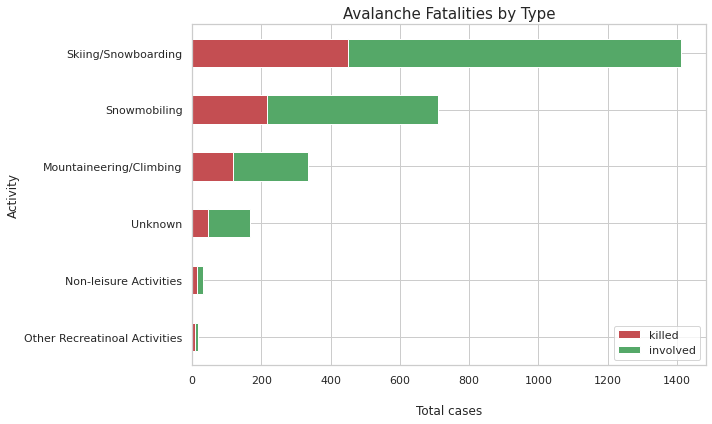

In [116]:
dat = (accidents.groupby('group_activity')
       .agg({'killed': 'sum', 'involved': 'sum'})
       .sort_values('killed'))

fig, ax = plt.subplots(figsize=(10,6))
dat.plot.barh(ax=ax, stacked=True, color=['r', 'g'])
plt.xlabel("\nTotal cases")
plt.ylabel("Activity")
plt.title("Avalanche Fatalities by Type", fontsize=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Plot of Number of Avalanches and number of deaths By date:

The bar Plot depicted below shows the number of avalanches and the number of deaths caused by avalanches in each month (make bars broken up by type?)

The purpose of this plot is to highlight whether avalanches tend to be more frequent at certain parts of the ski season than others. By including a line depicting deaths

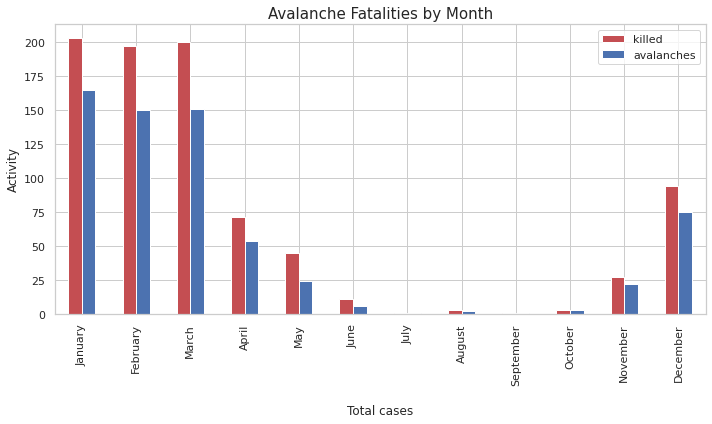

In [114]:
dat = (accidents.groupby('month')
        .agg({'killed':'sum', 'month':'size'})
        .rename(columns={'month':'avalanches'})
        .reset_index())
sort_order = ["January", "February", "March", "April", "May", "June", "July",
              "August", "September", "October", "November", "December"]
dat.index = pd.CategoricalIndex(dat['month'], categories=sort_order, ordered=True)
dat = dat.sort_index().drop(columns = ["month"])

fig, ax = plt.subplots(figsize=(10,6))
dat.plot.bar(ax=ax, color=['r', 'b'])
plt.xlabel("\nTotal cases")
plt.ylabel("Activity")
plt.title("Avalanche Fatalities by Month", fontsize=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Fatalities by State in the US, Province in Canada & Country in Europe

In [ ]:
# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y)
axs[1].plot(x, -y)

## Plan:

- investigate frequency of accidents per type of activity 
    - try to use beautiful soup to rename values in the description for the US data if we can't get the avalanche details thing sorted in question 1
    - use beautiful soup to rename values so that Type column in EU matches the activity column in Canada data
    - create bar graph
- investigate avalanche tendencies by date: See if there is a trend that there are more fatal avalanches later in the ski season than the start
    - plot number of deaths as a function of the date, removing the year from the date

- compare # of deaths or probability of fatal incident between activities or avalanche size. - will do depending on how data looks.
    
- prediction analysis:
    - use a prediction technique (likely random forests, but will use the answer in question 2)
    - as of now will only use avalanche Canada data unless we can scrape the data from US and EU to have the same variables but we are currently lost as to how to do so.

<span style="color:red">
2. You can run a prediction model with a smaller amount of data. Any method should be okay, but you will need to select less complex models (i.e. fewer features / bigger penalty for lasso, less deep trees). Cross-validation should do this automatically.
<br>
3. On the one hand, the prediction analysis would use the most ideas from the course. On the other hand, the other three bullets seem to be of more practical use. Both can lead to full marks. Do whatever you find more interesting. <br>
I know this is a draft, but for the final version, be sure to add markdown cells between the code saying what you're doing and why.
<br>
4. I'm happy with anything that includes a url. If there is no url, be sure to have the author(s), title, journal (if applicable), and year.
</span>